In [1]:
# import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image

import torch
from torch import nn
from torch.utils.data import Dataset
import pennylane as qml
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [96]:
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Brief Outline

The notebook will proceed in the following manner:

1. Brief description of Data
2. Using Classical LSTM to perform stock price prediction
3. Using classical ARIMA to perform stock price prediction
4. Using Multiple linear regression to perform stock price prediction 

## 1. Data

First, we read in the data, dropping the index and the date.

In [2]:
df = pd.read_csv('dataset_FTSE_prediction_v1.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
df=df.drop(columns=['ARIMA'])

We identify the dependent and independent variables:

In [3]:
target = "Close"

In [5]:
features = list(df.columns.difference(["Close"]))
features

['Adj Close',
 'BBB_20_2.0',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBP_20_2.0',
 'BBU_20_2.0',
 'CUMLOGRET_1',
 'Close_copy',
 'Crude Futures',
 'EMA_10',
 'EMA_20',
 'EMA_50',
 'FT3',
 'FT6',
 'FT9',
 'GBP USD ',
 'Gold in USD',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'SMA_10',
 'SMA_20',
 'SMA_50',
 'Volume']

## Data processing for time series model

To process the data, we first define few terms

In [6]:
sequence_length = window = 30 # Number of time steps that will be inputted into LSTM network and Number of Predicting days 
batch_size=16 # Number of training instances in the batch
torch.manual_seed(42)
random.seed(42)

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [7]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [8]:
df

,Adj Close,BBB_20_2.0,BBL_20_2.0,BBM_20_2.0,BBP_20_2.0,BBU_20_2.0,CUMLOGRET_1,Close,Crude Futures,EMA_10,...,GBP USD,Gold in USD,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,SMA_10,SMA_20,SMA_50,Volume,Close_copy
0,-2.117565,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.243124,-2.117565,1.500541,-9.214615,...,1.529613,1.234563,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.730166,-2.117565
1,-2.312586,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.482745,-2.312586,1.423609,-9.214615,...,1.462366,1.411190,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.160281,-2.312586
2,-2.604116,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.851864,-2.604116,1.423609,-9.214615,...,1.462366,1.411190,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.028158,-2.604116
3,-2.520689,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.744853,-2.520689,1.445590,-9.214615,...,1.395119,1.397119,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.619960,-2.520689
4,-2.271642,-1.416161,-7.846089,-8.197548,-1.587882,-8.374291,-2.431965,-2.271642,1.559810,-9.214615,...,1.260624,1.190869,-0.077292,0.000882,-0.083523,-9.189175,-8.197548,-6.432481,0.212893,-2.271642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3134,0.972282,-0.117595,0.764524,0.780643,0.142467,0.779948,0.948611,0.972282,0.570682,0.879767,...,-0.958536,1.575597,-0.350816,0.702786,-0.631190,0.868999,0.780643,0.749319,-1.251617,0.972282
3135,0.996293,-0.303076,0.786476,0.769910,0.407189,0.736435,0.969864,0.996293,0.543992,0.884342,...,-1.025783,1.573375,-0.305387,0.671263,-0.570851,0.883658,0.769910,0.748743,-1.223489,0.996293
3136,1.052475,-0.347235,0.791464,0.767120,0.805365,0.725847,1.019417,1.052475,0.572645,0.897109,...,-1.025783,1.576708,-0.221191,0.738941,-0.504421,0.902589,0.767120,0.747719,-0.489123,1.052475
3137,1.081259,-0.357591,0.792661,0.766495,1.003170,0.723395,1.044711,1.081259,0.572252,0.912179,...,-1.025783,1.594852,-0.130016,0.809806,-0.431612,0.924056,0.766495,0.747135,-0.800152,1.081259


The last step in the data processing is to prepare the data in a sequence of past observations. Preparation of the time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance and window decides how many days we want to predict for. If the sequence length is $n$ and window is $w$, then the LSTM considers the last $n$ observations to predict the next $w$ day price.

In [9]:
def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(len(dataset)-lookback-window):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback-1:i+lookback+window-1]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

X_ts, y_ts = create_dataset(
    df,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

print(X_ts.shape, y_ts.shape)

torch.Size([3079, 30, 24]) torch.Size([3079, 30])


In [10]:
indices = tf.range(start=0, limit=tf.shape(X_ts)[0])
shuffled_indices = tf.random.shuffle(indices)

In [11]:
X_ts = tf.gather(X_ts, shuffled_indices)
y_ts = tf.gather(y_ts, shuffled_indices)
print(X_ts.shape, y_ts.shape)
X_ts=torch.FloatTensor(np.array(X_ts))
y_ts=torch.FloatTensor(np.array(y_ts))
print(X_ts.shape, y_ts.shape)

(3079, 30, 24) (3079, 30)
torch.Size([3079, 30, 24]) torch.Size([3079, 30])


In [12]:
# Train test split
n=X_ts.shape[0] # get first dimension
size=int(n*0.9)
X_train_ts=X_ts[:size]
y_train_ts=y_ts[:size]
X_test_ts=X_ts[size:]
y_test_ts=y_ts[size:]
print('Shape of train is',X_train_ts.shape,'and',y_train_ts.shape)
print('Shape os test is',X_test_ts.shape,'and',y_test_ts.shape)

Shape of train is torch.Size([2771, 30, 24]) and torch.Size([2771, 30])
Shape os test is torch.Size([308, 30, 24]) and torch.Size([308, 30])


In [13]:
train_loader = DataLoader(data.TensorDataset(X_train_ts, y_train_ts), shuffle=True, batch_size=batch_size)
test_loader= DataLoader(data.TensorDataset(X_test_ts, y_test_ts), shuffle=True, batch_size=batch_size)

In [14]:
# The unknown data
X_check=(df[features].values)[len(df)-window-sequence_length+1:len(df)- window+1]
y_check=(df[target].values)[len(df)-window:len(df)]
torch.FloatTensor([X_check]).shape

<ipython-input-14-65eb19419169>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  torch.FloatTensor([X_check]).shape


torch.Size([1, 30, 24])

In [15]:
X_check

array([[ 1.08910894, -0.72207635,  1.08204197,  0.99933972, -1.20771297,
         0.89406971,  1.05159877,  1.08910894, -0.07539102,  1.08607964,
         1.02806264,  0.92689584, -0.0203494 ,  0.24239476,  0.68138609,
        -0.82404156,  1.5556016 , -0.63029335, -0.01196808, -0.67524222,
         1.09284983,  0.99933972,  0.97500514, -0.38975293],
       [ 1.02738588, -0.65796763,  1.0608889 ,  0.98931125, -1.53972768,
         0.89549633,  0.99731787,  1.02738588, -0.08677384,  1.05813739,
         1.01203695,  0.91957167, -0.02763145,  0.2301629 ,  0.66453088,
        -0.89128884,  1.57929994, -0.73802892, -0.26755709, -0.69940345,
         1.07922104,  0.98931125,  0.96712673, -0.60155586],
       [ 1.01461028, -0.60403668,  1.04108375,  0.97877923, -1.43903188,
         0.89456019,  0.98604624,  1.01461028, -0.07382097,  1.03322342,
         0.99657464,  0.91222086, -0.03491967,  0.2178975 ,  0.64756148,
        -0.89128884,  1.59633313, -0.82536866, -0.42315524, -0.73756953,
  

In [16]:
y_check

array([1.18084694, 1.13097595, 1.18515678, 1.16991842, 1.12820534,
       1.22040511, 1.26858296, 1.1232798 , 1.09711292, 0.91609967,
       0.8657669 , 0.79388494, 0.72030983, 0.71322938, 0.73323934,
       0.80973899, 0.82990288, 0.83759903, 0.83759903, 1.03215749,
       1.04554877, 0.99229147, 1.03138787, 1.0133789 , 0.9904444 ,
       0.97228151, 0.99629347, 1.0524753 , 1.08125887, 1.08125887])

In [17]:
# for X, y in train_loader:
#     print(X)
#     print(y)

## Classical LSTM

We first define train_model: function to train the model based on the batches of data
We print the loss at the end to understand how the model is performing with regards to the data.

In [18]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Running the Classical LSTM

In the following code, we train LSTM to predict future stock prices, and then test it on the test dataset. 

In [28]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1) # The output dimesion is set as window

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(out_)
        return torch.squeeze(out)

In [29]:
learning_rate = 0.005
num_hidden_units = 200

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [30]:
lstm_loss_train = []
lstm_loss_test=[]
num_epoch=150
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model_lstm, loss_function)
    lstm_loss_train.append(train_loss)
    lstm_loss_test.append(test_loss)

Epoch 0
---------
Train loss: 0.15504045461186733
Test loss: 0.08008267059922218
Epoch 1
---------
Train loss: 0.08075721399194893
Test loss: 0.10840049404650927
Epoch 2
---------
Train loss: 0.05260605725791605
Test loss: 0.04408582067117095
Epoch 3
---------
Train loss: 0.030450548141680914
Test loss: 0.025957097858190538
Epoch 4
---------
Train loss: 0.01960530115997997
Test loss: 0.018649040814489128
Epoch 5
---------
Train loss: 0.01563764707420835
Test loss: 0.012525695888325573
Epoch 6
---------
Train loss: 0.011385485390736454
Test loss: 0.010979733313433826
Epoch 7
---------
Train loss: 0.010382551357321355
Test loss: 0.012691252678632737
Epoch 8
---------
Train loss: 0.008472778031538272
Test loss: 0.00897274650633335
Epoch 9
---------
Train loss: 0.007157710651149866
Test loss: 0.007018500124104321
Epoch 10
---------
Train loss: 0.00641529791421075
Test loss: 0.006420658435672522
Epoch 11
---------
Train loss: 0.005728463228824067
Test loss: 0.005591188929975033
Epoch 12
---

Test loss: 0.0030284900043625385
Epoch 97
---------
Train loss: 0.0030912203097384124
Test loss: 0.0034860393207054585
Epoch 98
---------
Train loss: 0.0019556710614632793
Test loss: 0.002751001750584692
Epoch 99
---------
Train loss: 0.000855458411923342
Test loss: 0.0017210266494657844
Epoch 100
---------
Train loss: 0.00046123152290304973
Test loss: 0.0014684092457173392
Epoch 101
---------
Train loss: 0.0003284866231307655
Test loss: 0.0011514193698531016
Epoch 102
---------
Train loss: 0.0002942298248864512
Test loss: 0.0011099663330242037
Epoch 103
---------
Train loss: 0.00026932690077997884
Test loss: 0.0011096885580627713
Epoch 104
---------
Train loss: 0.00023794950915356007
Test loss: 0.0011895171017386019
Epoch 105
---------
Train loss: 0.00024250813737450083
Test loss: 0.001253887583152391
Epoch 106
---------
Train loss: 0.00030095446684221124
Test loss: 0.0011933410889469088
Epoch 107
---------
Train loss: 0.00027297572289652395
Test loss: 0.001655146401026286
Epoch 108
-

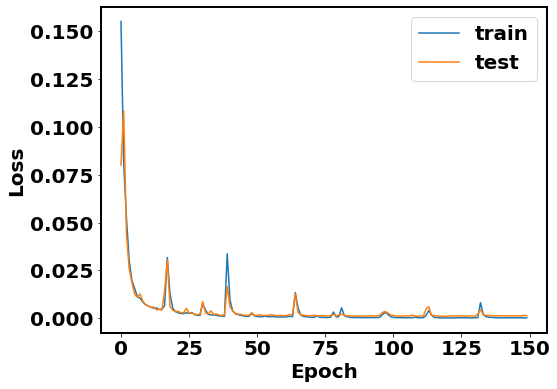

In [95]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), lstm_loss_train, label='train')
plt.plot(range(num_epoch), lstm_loss_test, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [37]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [38]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train_ts, y_train_ts), shuffle=False, batch_size=batch_size)
y_train_pred_lstm=predict(train_eval_loader, model_lstm)
y_train_lstm=[]
for X, y in train_eval_loader:
    y_train_lstm.append(y)
# Prepare data to evaluate test accuracy of lstm
test_eval_loader = DataLoader(data.TensorDataset(X_test_ts, y_test_ts), shuffle=False, batch_size=batch_size)
y_test_pred_lstm=predict(test_eval_loader, model_lstm)
y_test_lstm=[]
for X, y in test_eval_loader:
    y_test_lstm.append(y)

In [39]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [40]:
mae_train_lstm, rmse_train_lstm= cal_metrics(y_train_lstm,y_train_pred_lstm)
print('MAE train error is',mae_train_lstm)
print('RMSE train error is',rmse_train_lstm)
mae_test_lstm, rmse_test_lstm= cal_metrics(y_test_lstm,y_test_pred_lstm)
print('MAE test error is',mae_test_lstm)
print('RMSE test error is',rmse_test_lstm)

MAE train error is 5.286083262542198
RMSE train error is 8.534762842901822
MAE test error is 9.167039108276366
RMSE test error is 22.353366088867187


In [41]:
y_check_pred_lstm = model_lstm(torch.FloatTensor([X_check]))
y_check_pred_lstm = y_check_pred_lstm.detach().numpy()

mae_check_lstm = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean)
print('MAE check error  : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_lstm* target_stdev + target_mean, squared=False)
print('RMSE check error : ',rmse_check_lstm)

MAE check error  :  29.459833984375017
RMSE check error :  48.98254608380377


## Running the ARIMA 

In [42]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

<ipython-input-42-c2c42f0d7345>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [43]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
train_data_arima=df[target].values[:len(df)-window] # train on full data
check_data_arima=df[target].values[len(df)-window:]

<ipython-input-43-de4a1ff72067>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [44]:
print(check_data_arima)

[1.18084694 1.13097595 1.18515678 1.16991842 1.12820534 1.22040511
 1.26858296 1.1232798  1.09711292 0.91609967 0.8657669  0.79388494
 0.72030983 0.71322938 0.73323934 0.80973899 0.82990288 0.83759903
 0.83759903 1.03215749 1.04554877 0.99229147 1.03138787 1.0133789
 0.9904444  0.97228151 0.99629347 1.0524753  1.08125887 1.08125887]


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8823.545, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4877.183, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-5645.045, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-5653.338, Time=0.77 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-5649.352, Time=1.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-5643.928, Time=0.57 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-5643.970, Time=0.19 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.18 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-5641.260, Time=1.36 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-5651.361, Time=1.70 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 6.551 seconds
                               SARIMAX Results                                
Dep. Variable:   

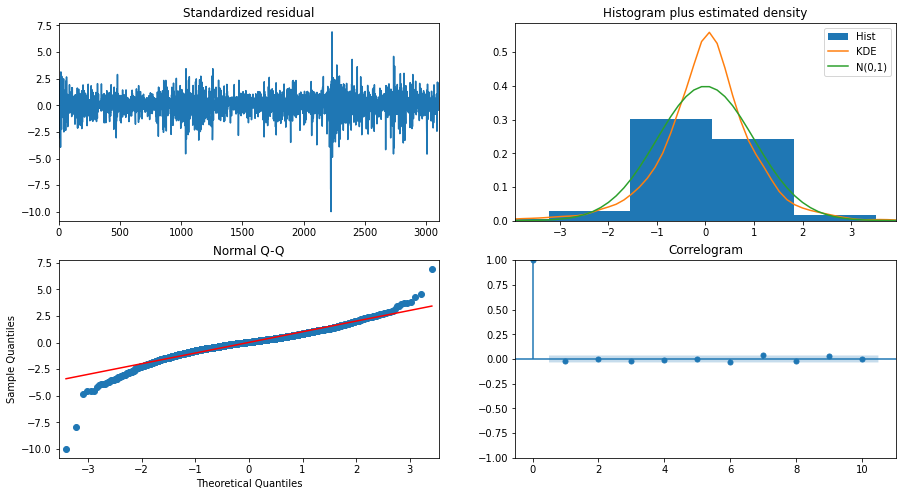

In [45]:
model_autoARIMA = auto_arima(train_data_arima, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [46]:
import statsmodels.api as sm
model = ARIMA(train_data_arima, order=(2,0,1))  
fitted = model.fit()  
print(fitted.summary())

C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3109
Model:                 ARIMA(2, 0, 1)   Log Likelihood                2830.680
Date:                Thu, 11 Jan 2024   AIC                          -5651.359
Time:                        11:27:11   BIC                          -5621.149
Sample:                             0   HQIC                         -5640.512
                               - 3109                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0712      0.380     -0.188      0.851      -0.815       0.673
ar.L1          0.0617      0.033      1.893      0.058      -0.002       0.126
ar.L2          0.9300      0.033     28.590      0.0

In [47]:
# Forecast
y_check_pred_arima = fitted.forecast(window, alpha=0.05)  # 95% conf

C:\anaconda_installed\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [48]:
mae_check_arima = mean_absolute_error(y_check* target_stdev + target_mean,y_check_pred_arima* target_stdev + target_mean)
print('Mean absolute error(check) : ',mae_check_arima)
rmse_check_arima = mean_squared_error(y_check* target_stdev + target_mean,y_check_pred_arima* target_stdev + target_mean, squared=False)
print('Root Mean Squared error(check) : ',rmse_check_arima)

Mean absolute error(check) :  167.56200461802888
Root Mean Squared error(check) :  193.08683898071834


## Data processing for regression model

In [49]:
# Data for regression model
sequence_length_reg = window_reg =30 # Number of time steps that will be inputted into LSTM network

def create_dataset_reg(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(len(dataset)-lookback-window):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback-1:i+lookback+window-1]
        X_store.append(X)
        y_store.append(y)
    return X_store,y_store

X_reg,y_reg = create_dataset_reg(
    df,
    target=target,
    features=features,
    lookback=sequence_length_reg, window=window_reg)

print(np.array(X_reg).shape, np.array(y_reg).shape)

(3079, 30, 24) (3079, 30)


In [50]:
X_reg = tf.gather(X_reg, shuffled_indices)
y_reg = tf.gather(y_reg, shuffled_indices)

In [51]:
# Train test split
m=np.array(X_reg).shape[0] # get first dimension
size=int(m*0.9)
X_train_reg=X_reg[:size]
y_train_reg=y_reg[:size]
X_test_reg=X_reg[size:]
y_test_reg=y_reg[size:]
print('Shape of train is',np.array(X_train_reg).shape,'and',np.array(y_train_reg).shape)
print('Shape os test is',np.array(X_test_reg).shape,'and',np.array(y_test_reg).shape)

Shape of train is (2771, 30, 24) and (2771, 30)
Shape os test is (308, 30, 24) and (308, 30)


In [52]:
X_train_reg_=np.array([inner for outer in X_train_reg for inner in outer])
print(X_train_reg_.shape)
y_train_reg_=np.array([inner for outer in y_train_reg for inner in outer])
print(y_train_reg_.shape)

(83130, 24)
(83130,)


In [53]:
X_test_reg_=np.array([inner for outer in X_test_reg for inner in outer])
print(X_test_reg_.shape)
y_test_reg_=np.array([inner for outer in y_test_reg for inner in outer])
print(y_test_reg_.shape)

(9240, 24)
(9240,)


In [54]:
# Prepare test data
X_check_reg=(df[features].values)[len(df)-window_reg-sequence_length_reg+1:len(df)- window_reg+1]
y_check_reg=(df[target].values)[len(df)-window_reg:len(df)]

## Linear regression model

In [55]:
from sklearn.linear_model import LinearRegression
#Creating the Regressor
regressor = LinearRegression()
regressor.fit(X_train_reg_, y_train_reg_)

LinearRegression()

In [56]:
y_train_pred_mlr=regressor.predict(X_train_reg_)
mae_train_mlr = mean_absolute_error(y_train_reg_* target_stdev + target_mean,y_train_pred_mlr* target_stdev + target_mean)
print('MAE train Error : ',mae_train_mlr)
rmse_train_mlr = mean_squared_error(y_train_reg_* target_stdev + target_mean,y_train_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE train Error : ',rmse_train_mlr)

MAE train Error :  164.09589708723485
RMSE train Error :  227.28661774273726


In [57]:
y_test_pred_mlr=regressor.predict(X_test_reg_)
mae_test_mlr = mean_absolute_error(y_test_reg_* target_stdev + target_mean,y_test_pred_mlr* target_stdev + target_mean)
print('MAE test Error : ',mae_test_mlr)
rmse_test_mlr = mean_squared_error(y_test_reg_* target_stdev + target_mean,y_test_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE test Error : ',rmse_test_mlr)

MAE test Error :  162.89248485226412
RMSE test Error :  224.71638965442867


In [58]:
y_check_pred_mlr = regressor.predict(X_check_reg)
mae_check_mlr = mean_absolute_error(y_check_reg* target_stdev + target_mean,y_check_pred_mlr* target_stdev + target_mean)
print('MAE check error : ',mae_check_mlr)
rmse_check_mlr = mean_squared_error(y_check_reg* target_stdev + target_mean,y_check_pred_mlr* target_stdev + target_mean, squared=False)
print('RMSE check error: ',rmse_check_mlr)

MAE check error :  481.13985192189915
RMSE check error:  491.53032208186283


## XGboost

In [59]:
import xgboost as xg

In [60]:
# Instantiation 
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                   seed = 123) 
# Fitting the model 
xgb_r.fit(X_train_reg_, y_train_reg_) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [61]:
# Predict the model 
y_train_pred_xg = xgb_r.predict(X_train_reg_) 
mae_train_xg = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_xg* target_stdev + target_mean)
print('MAE train: ',mae_train_xg)
rmse_train_xg = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_xg* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_xg)

MAE train:  11.776860461400817
RMSE train:  15.328551771821145


In [62]:
# Predict the model 
y_test_pred_xg = xgb_r.predict(X_test_reg_) 
mae_test_xg = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_xg* target_stdev + target_mean)
print('MAE test: ',mae_test_xg)
rmse_test_xg = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_xg* target_stdev + target_mean, squared=False)
print('RMSE test: ',rmse_test_xg)

MAE test:  11.778206612723212
RMSE test:  15.427405310178957


In [63]:
# Predict the model 
y_check_pred_xg = xgb_r.predict(X_check_reg) 
mae_check_xg = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_xg* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_xg)
rmse_check_xg = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_xg* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_xg)

Mean absolute Error :  40.6940201822916
Root Mean Squared Error :  137.3179632490203


## ANN

In [64]:
from tensorflow.keras import regularizers, initializers
from keras.layers import Input, Dense, Reshape, Embedding, concatenate, Dropout, Flatten
from keras.layers.merge import Dot
from keras.preprocessing import sequence
from keras import Model

In [65]:
input_ = Input((len(features),)) # feature

den1=Dense(256, use_bias=True,activation='relu')(input_)

den2=Dense(128, use_bias=True,activation='relu')(den1)

den3=Dense(64, use_bias=True,activation='relu')(den2)

den4=Dense(32, use_bias=True,activation='relu')(den3)

den5=Dense(1, use_bias=True,activation='linear')(den4)

model = Model(inputs=[input_], outputs=den5)

In [66]:
import tensorflow as tf

In [67]:
loss_fn = tf.keras.losses.MeanSquaredError()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(opt, loss=loss_fn)

In [68]:
model_history = model.fit(X_train_reg_, y_train_reg_,
                    validation_data=(X_test_reg_, y_test_reg_),
                   batch_size=16, 
                   epochs=150,  # total epoch
                   )

Epoch 1/150
5196/5196 [==============================] - 7s 1ms/step - loss: 0.0503 - val_loss: 0.0180
Epoch 2/150
5196/5196 [==============================] - 5s 1ms/step - loss: 0.0127 - val_loss: 0.0085
Epoch 3/150
5196/5196 [==============================] - 6s 1ms/step - loss: 0.0081 - val_loss: 0.0067
Epoch 4/150
5196/5196 [==============================] - 6s 1ms/step - loss: 0.0062 - val_loss: 0.0050
Epoch 5/150
5196/5196 [==============================] - 6s 1ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 6/150
5196/5196 [==============================] - 6s 1ms/step - loss: 0.0044 - val_loss: 0.0080
Epoch 7/150
5196/5196 [==============================] - 6s 1ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/150
5196/5196 [==============================] - 6s 1ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 9/150
5196/5196 [==============================] - 6s 1ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 10/150
5196/5196 [==============================] - 6s 1ms/step - l

5196/5196 [==============================] - 5s 1ms/step - loss: 4.6615e-04 - val_loss: 3.2842e-04
Epoch 77/150
5196/5196 [==============================] - 5s 1ms/step - loss: 4.9266e-04 - val_loss: 3.3905e-04
Epoch 78/150
5196/5196 [==============================] - 5s 1ms/step - loss: 4.6981e-04 - val_loss: 3.1398e-04
Epoch 79/150
5196/5196 [==============================] - 5s 1ms/step - loss: 4.5692e-04 - val_loss: 4.8043e-04
Epoch 80/150
5196/5196 [==============================] - 5s 1ms/step - loss: 4.5266e-04 - val_loss: 0.0012
Epoch 81/150
5196/5196 [==============================] - 5s 1ms/step - loss: 4.6136e-04 - val_loss: 2.8765e-04
Epoch 82/150
5196/5196 [==============================] - 5s 1ms/step - loss: 4.4229e-04 - val_loss: 4.0636e-04
Epoch 83/150
5196/5196 [==============================] - 5s 1ms/step - loss: 4.4074e-04 - val_loss: 4.8889e-04
Epoch 84/150
5196/5196 [==============================] - 7s 1ms/step - loss: 4.4461e-04 - val_loss: 3.5132e-04
Epoch 85/

Epoch 149/150
5196/5196 [==============================] - 7s 1ms/step - loss: 2.6576e-04 - val_loss: 2.9160e-04
Epoch 150/150
5196/5196 [==============================] - 7s 1ms/step - loss: 2.6338e-04 - val_loss: 1.7951e-04


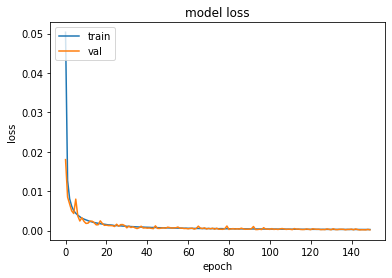

In [69]:
import keras
from matplotlib import pyplot as plt
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
# Predict the model 
y_train_pred_ann = model.predict(X_train_reg_) 
mae_train_ann = mean_absolute_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean)
print('MAE train: ',mae_train_ann)
rmse_train_ann = mean_squared_error(y_train_reg_* target_stdev + target_mean, y_train_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE train: ',rmse_train_ann)

MAE train:  5.980096379306138
RMSE train:  8.520438203236516


In [71]:
# Predict the model 
y_test_pred_ann = model.predict(X_test_reg_) 
mae_test_ann = mean_absolute_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean)
print('MAE test: ',mae_test_ann)
rmse_test_ann = mean_squared_error(y_test_reg_* target_stdev + target_mean, y_test_pred_ann* target_stdev + target_mean, squared=False)
print('RMSE test : ',rmse_test_ann)

MAE test:  6.0186989101393396
RMSE test :  8.704440627988465


In [72]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense (Dense)               (None, 256)               6400      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 49,665
Trainable params: 49,665
Non-trainable p

In [73]:
y_check_pred_nn = model.predict(X_check_reg)
y_check_pred_nn=y_check_pred_nn.flatten()
mae_check_nn = mean_absolute_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean)
print('Mean absolute Error : ',mae_check_nn)
rmse_check_nn = mean_squared_error(y_check_reg* target_stdev + target_mean, y_check_pred_nn* target_stdev + target_mean, squared=False)
print('Root Mean Squared Error : ',rmse_check_nn)

Mean absolute Error :  17.814563802083377
Root Mean Squared Error :  47.42759347531046


In [74]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_train_lstm,mae_test_lstm, rmse_train_lstm,rmse_test_lstm], 
    ["Multiple linear regression",mae_train_mlr,mae_test_mlr, rmse_train_mlr,rmse_test_mlr], 
      ["XGboost", mae_train_xg, mae_test_xg, rmse_train_xg,rmse_test_xg],
    ["ANN", mae_train_ann, mae_test_ann,  rmse_train_ann ,rmse_test_ann]
]
 
# create header
head = ["Model","Train MAE" ,"Test MAE", "Train RMSE","Test RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+-------------+------------+--------------+-------------+
| Model                      |   Train MAE |   Test MAE |   Train RMSE |   Test RMSE |
+============================+=============+============+==============+=============+
| LSTM                       |     5.28608 |    9.16704 |      8.53476 |    22.3534  |
+----------------------------+-------------+------------+--------------+-------------+
| Multiple linear regression |   164.096   |  162.892   |    227.287   |   224.716   |
+----------------------------+-------------+------------+--------------+-------------+
| XGboost                    |    11.7769  |   11.7782  |     15.3286  |    15.4274  |
+----------------------------+-------------+------------+--------------+-------------+
| ANN                        |     5.9801  |    6.0187  |      8.52044 |     8.70444 |
+----------------------------+-------------+------------+--------------+-------------+


## Comparison

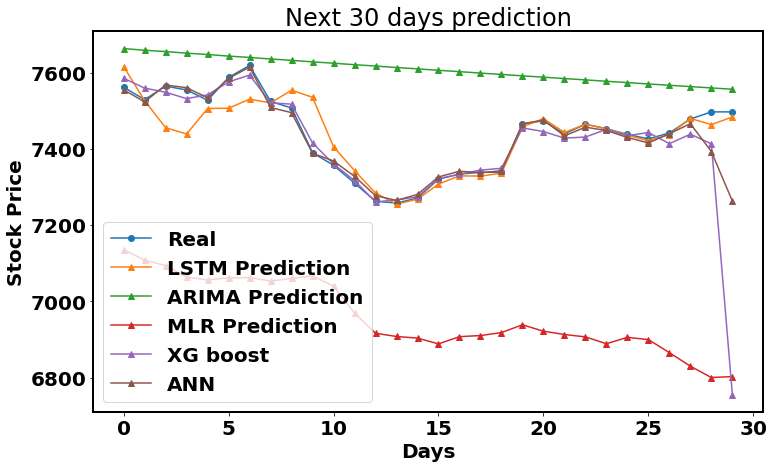

In [76]:
plt.figure(figsize=(12, 7))
# plt.plot(y_test_reg* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check* target_stdev + target_mean, label = "Real",marker='o')
plt.plot(y_check_pred_lstm* target_stdev + target_mean, label = "LSTM Prediction",marker='^')
plt.plot(y_check_pred_arima* target_stdev + target_mean, label = "ARIMA Prediction",marker='^')
plt.plot(y_check_pred_mlr* target_stdev + target_mean, label = "MLR Prediction",marker='^')
plt.plot(y_check_pred_xg* target_stdev + target_mean, label = "XG boost",marker='^')
plt.plot(y_check_pred_nn* target_stdev + target_mean, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title('Next '+str(window)+' days prediction')
plt.legend()
plt.show()

In [94]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_check_lstm, rmse_check_lstm], 
    ["ARIMA", mae_check_arima, rmse_check_arima], 
    ["Multiple linear regression",mae_test_mlr, rmse_check_mlr], 
      ["XGboost", mae_check_xg, rmse_check_xg],
    ["ANN", mae_check_nn, rmse_check_nn]
]
 
# create header
head = ["Model","Check MAE" , "Check RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+-------------+--------------+
| Model                      |   Check MAE |   Check RMSE |
+============================+=============+==============+
| LSTM                       |     29.4598 |      48.9825 |
+----------------------------+-------------+--------------+
| ARIMA                      |    167.562  |     193.087  |
+----------------------------+-------------+--------------+
| Multiple linear regression |    162.892  |     491.53   |
+----------------------------+-------------+--------------+
| XGboost                    |     40.694  |     137.318  |
+----------------------------+-------------+--------------+
| ANN                        |     17.8146 |      47.4276 |
+----------------------------+-------------+--------------+


In [78]:
low_=0
high_=window

In [79]:
list_real=list(y_check* target_stdev + target_mean)[low_:high_]
list_real_=list(y_check_reg* target_stdev + target_mean)[low_:high_]
list_lstm=list(y_check_pred_lstm* target_stdev + target_mean)[low_:high_]
list_arima=list(y_check_pred_arima* target_stdev + target_mean)[low_:high_]
list_mlr=list(y_check_pred_mlr* target_stdev + target_mean)[low_:high_]
list_xg=list(y_check_pred_xg* target_stdev + target_mean)[low_:high_]
list_nn=list(y_check_pred_nn* target_stdev + target_mean)[low_:high_]

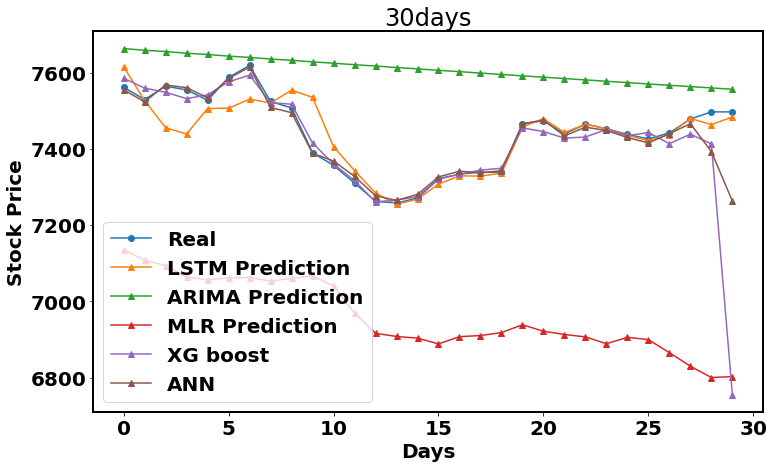

In [80]:
plt.figure(figsize=(12, 7))
plt.plot(list_real_, label = "Real",marker='o')
# plt.plot(list_real, label = "Real",marker='o')
plt.plot(list_lstm, label = "LSTM Prediction",marker='^')
plt.plot(list_arima, label = "ARIMA Prediction",marker='^')
plt.plot(list_mlr, label = "MLR Prediction",marker='^')
plt.plot(list_xg, label = "XG boost",marker='^')
plt.plot(list_nn, label = "ANN",marker='^')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.title(str(window)+'days')
plt.legend()
plt.show()

In [81]:
save_data=[list_real,list_lstm,
          list_arima,list_mlr,
          list_xg,list_nn]

In [82]:
import csv 
# name of csv file   
filename = "Stock Prediction_predict_3_ver_2_DRC.csv"
      
# writing to csv file   
with open(filename, 'w') as csvfile:   
    # creating a csv writer object   
    csvwriter = csv.writer(csvfile)     
          
    # writing the data rows   
    csvwriter.writerows(save_data)

In [83]:
mae_check_lstm = mean_absolute_error(list_real,list_lstm)
print('Mean absolute Error : ',mae_check_lstm)
rmse_check_lstm = mean_squared_error(list_real,list_lstm, squared=False)
print('Root Mean Squared Error : ',rmse_check_lstm)

Mean absolute Error :  29.459833984375017
Root Mean Squared Error :  48.98254608380377


In [84]:
mae_check_arima = mean_absolute_error(list_real,list_arima)
print('Mean absolute Error : ',mae_check_arima)
rmse_check_arima = mean_squared_error(list_real,list_arima, squared=False)
print('Root Mean Squared Error : ',rmse_check_arima)

Mean absolute Error :  167.56200461802888
Root Mean Squared Error :  193.08683898071834


In [85]:
mae_check_mlr = mean_absolute_error(list_real,list_mlr)
print('Mean absolute Error : ',mae_check_mlr)
rmse_check_mlr = mean_squared_error(list_real,list_mlr, squared=False)
print('Root Mean Squared Error : ',rmse_check_mlr)

Mean absolute Error :  481.13985192189915
Root Mean Squared Error :  491.53032208186283


In [86]:
mae_check_xg = mean_absolute_error(list_real,list_xg)
print('Mean absolute Error : ',mae_check_xg)
rmse_check_xg = mean_squared_error(list_real, list_xg, squared=False)
print('Root Mean Squared Error : ',rmse_check_xg)

Mean absolute Error :  40.6940201822916
Root Mean Squared Error :  137.3179632490203


In [87]:
mae_check_nn = mean_absolute_error(list_real,list_nn)
print('Mean absolute Error : ',mae_check_nn)
rmse_check_nn = mean_squared_error(list_real, list_nn, squared=False)
print('Root Mean Squared Error : ',rmse_check_nn)

Mean absolute Error :  17.814563802083377
Root Mean Squared Error :  47.42759347531046


In [88]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["LSTM", mae_check_lstm, rmse_check_lstm], 
    ["ARIMA", mae_check_arima, rmse_check_arima], 
    ["Multiple linear regression",mae_test_mlr, rmse_check_mlr], 
      ["XGboost", mae_check_xg, rmse_check_xg],
    ["ANN", mae_check_nn, rmse_check_nn]
]
 
# create header
head = ["Model","Test MAE" , "Test RMSE"]
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+------------+-------------+
| Model                      |   Test MAE |   Test RMSE |
+============================+============+=============+
| LSTM                       |    29.4598 |     48.9825 |
+----------------------------+------------+-------------+
| ARIMA                      |   167.562  |    193.087  |
+----------------------------+------------+-------------+
| Multiple linear regression |   162.892  |    491.53   |
+----------------------------+------------+-------------+
| XGboost                    |    40.694  |    137.318  |
+----------------------------+------------+-------------+
| ANN                        |    17.8146 |     47.4276 |
+----------------------------+------------+-------------+


In [89]:
df_=pd.read_csv('Stock Prediction_predict_3_ver_2_DRC.csv',header=None)  

In [90]:
result_real=df_.iloc[0,:].values
result_lstm=df_.iloc[1,:].values
result_arima=df_.iloc[2,:].values
result_mlr=df_.iloc[3,:].values
result_xg=df_.iloc[4,:].values
result_nn=df_.iloc[5,:].values

In [91]:
from sklearn.metrics import r2_score
print ('R2 score between real and lstm',r2_score(result_real, result_lstm))
print ('R2 score between real and ARIMA',r2_score(result_real, result_arima))
print ('R2 score between real and MLR',r2_score(result_real, result_mlr))
print ('R2 score between real and xg',r2_score(result_real, result_xg))
print ('R2 score between real and nn',r2_score(result_real, result_nn))

R2 score between real and lstm 0.7605755491306959
R2 score between real and ARIMA -2.720413100805737
R2 score between real and MLR -23.10940252673855
R2 score between real and xg -0.8816571154100596
R2 score between real and nn 0.7755353175040689


In [92]:
def accuracy(y_true, y_pred, threshold):
    c=0
    for i in range(len(y_true)):
        if abs(y_true[i]-y_pred[i])<threshold:
            c=c+1
    return c/len(y_true)

In [93]:
threshold=100
print('The mean absolute error between real and lstm is',accuracy(result_real, result_lstm,threshold))
print('The mean absolute error between real and arima is',accuracy(result_real, result_arima,threshold))
print('The mean absolute error between real and MLR is',accuracy(result_real, result_mlr,threshold))
print('The mean absolute error between real and xg is',accuracy(result_real, result_xg,threshold))
print('The mean absolute error between real and nn is',accuracy(result_real, result_nn,threshold))

The mean absolute error between real and lstm is 0.9
The mean absolute error between real and arima is 0.23333333333333334
The mean absolute error between real and MLR is 0.0
The mean absolute error between real and xg is 0.9666666666666667
The mean absolute error between real and nn is 0.9333333333333333
